# Original vs simulated counts

This notebook tests the hypothesis that the VAE isn’t adequately accounting for low read counts.

Say we have an experiment with low read depth where a set of genes have 0 expression (i.e. not detectable).
After going through the VAE shifting process, the gene counts might get compressed (i.e. very low gene counts are increased and very high gene counts are decreased) so that the new simulated counts for these originally 0-expressed genes, which should have a high error rate and therefore not found to be DE by DESeq, can be found as DE by DESeq with the artificial shift in values. If this is the case, we will need a way to re-scale values to account for the read depth differences.

In [1]:
%load_ext autoreload
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ponyo import utils
from generic_expression_patterns_modules import ranking

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)
local_dir = params["local_dir"]
dataset_name = params["dataset_name"]
project_id = params["project_id"]
template_filename = os.path.join(
    base_dir, dataset_name, params["processed_template_filename"]
)

# Directory containing simulated experiments
simulated_dir = os.path.join(local_dir, "pseudo_experiment")
run = 4

In [3]:
# Read template experiment
template = pd.read_csv(template_filename, sep="\t", index_col=0, header=0)

In [4]:
def scatter_plot_original_vs_simulated(
    ncols, nrows, fig_width, fig_height, num_simulated, by_sample_or_gene
):
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(fig_width, fig_height))
    axes = axes.ravel()

    if by_sample_or_gene == "sample":
        for i in range(num_simulated):
            # Get simulated filename
            simulated_filename = os.path.join(
                simulated_dir, f"selected_simulated_data_{project_id}_{i}_processed.txt"
            )

            # Read simulated experiment
            simulated = pd.read_csv(simulated_filename, sep="\t", index_col=0, header=0)

            # Create dataframe with columns
            # Sample id | total counts across genes original (template)| total counts across genes after VAE (simulated)
            template_sample_counts = template.sum(axis=1)
            simulated_sample_counts = simulated.sum(axis=1)

            sample_counts = template_sample_counts.to_frame("Original counts").merge(
                simulated_sample_counts.to_frame("Simulated counts"),
                left_index=True,
                right_index=True,
            )

            # Plot per sample
            f = sns.scatterplot(
                data=sample_counts,
                x="Simulated counts",
                y="Original counts",
                alpha=0.8,
                ax=axes[i],
            )

            min_ = sample_counts.min().min()
            max_ = sample_counts.max().max()
            f.plot([min_, max_], [min_, max_], "k--")

            axes[i].set_ylabel("")
            axes[i].set_xlabel("")

        fig.text(
            0.5,
            0.0,
            "Simulated counts (after VAE)",
            ha="center",
            fontsize=14,
            fontname="Verdana",
        )
        fig.text(
            0.08,
            0.5,
            "Actual counts",
            va="center",
            rotation="vertical",
            fontsize=14,
            fontname="Verdana",
        )
        fig.suptitle(
            "Actual vs simulated counts per sample",
            fontsize=16,
            fontname="Verdana",
        )
    elif by_sample_or_gene == "gene":
        for i in range(num_simulated):
            # Get simulated filename
            simulated_filename = os.path.join(
                simulated_dir, f"selected_simulated_data_{project_id}_{i}_processed.txt"
            )

            # Read simulated experiment
            simulated = pd.read_csv(simulated_filename, sep="\t", index_col=0, header=0)

            # Create dataframe with columns
            # Gene id | total counts across samples original (template)| total counts across samples after VAE (simulated)
            template_gene_counts = template.sum()
            simulated_gene_counts = simulated.sum()
            # template_gene_counts = template.iloc[1]
            # simulated_gene_counts = simulated.iloc[1]

            gene_counts = template_gene_counts.to_frame("Original counts").merge(
                simulated_gene_counts.to_frame("Simulated counts"),
                left_index=True,
                right_index=True,
            )

            # Plot per sample
            g = sns.scatterplot(
                data=gene_counts,
                x="Simulated counts",
                y="Original counts",
                alpha=0.3,
                ax=axes[i],
            )
            # axes[i].hexbin(x=gene_counts["Simulated counts"],
            #               y=gene_counts["Original counts"],
            #               gridsize=100
            #              )
            # axes[i].set_ylim([0, 0.1e7])
            # axes[i].set_xlim([0, 0.1e7])

            min_ = gene_counts.min().min()
            max_ = gene_counts.max().max()
            g.plot([min_, max_], [min_, max_], "k--")
            g.plot([0, 0.1e7], [0, 0.1e7], "k--")
            axes[i].set_ylabel("")
            axes[i].set_xlabel("")

        fig.text(
            0.5,
            0.0,
            "Simulated counts (after VAE)",
            ha="center",
            fontsize=14,
            fontname="Verdana",
        )
        fig.text(
            0.08,
            0.5,
            "Actual counts",
            va="center",
            rotation="vertical",
            fontsize=14,
            fontname="Verdana",
        )
        fig.suptitle(
            "Actual vs simulated counts per gene",
            fontsize=16,
            fontname="Verdana",
        )

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


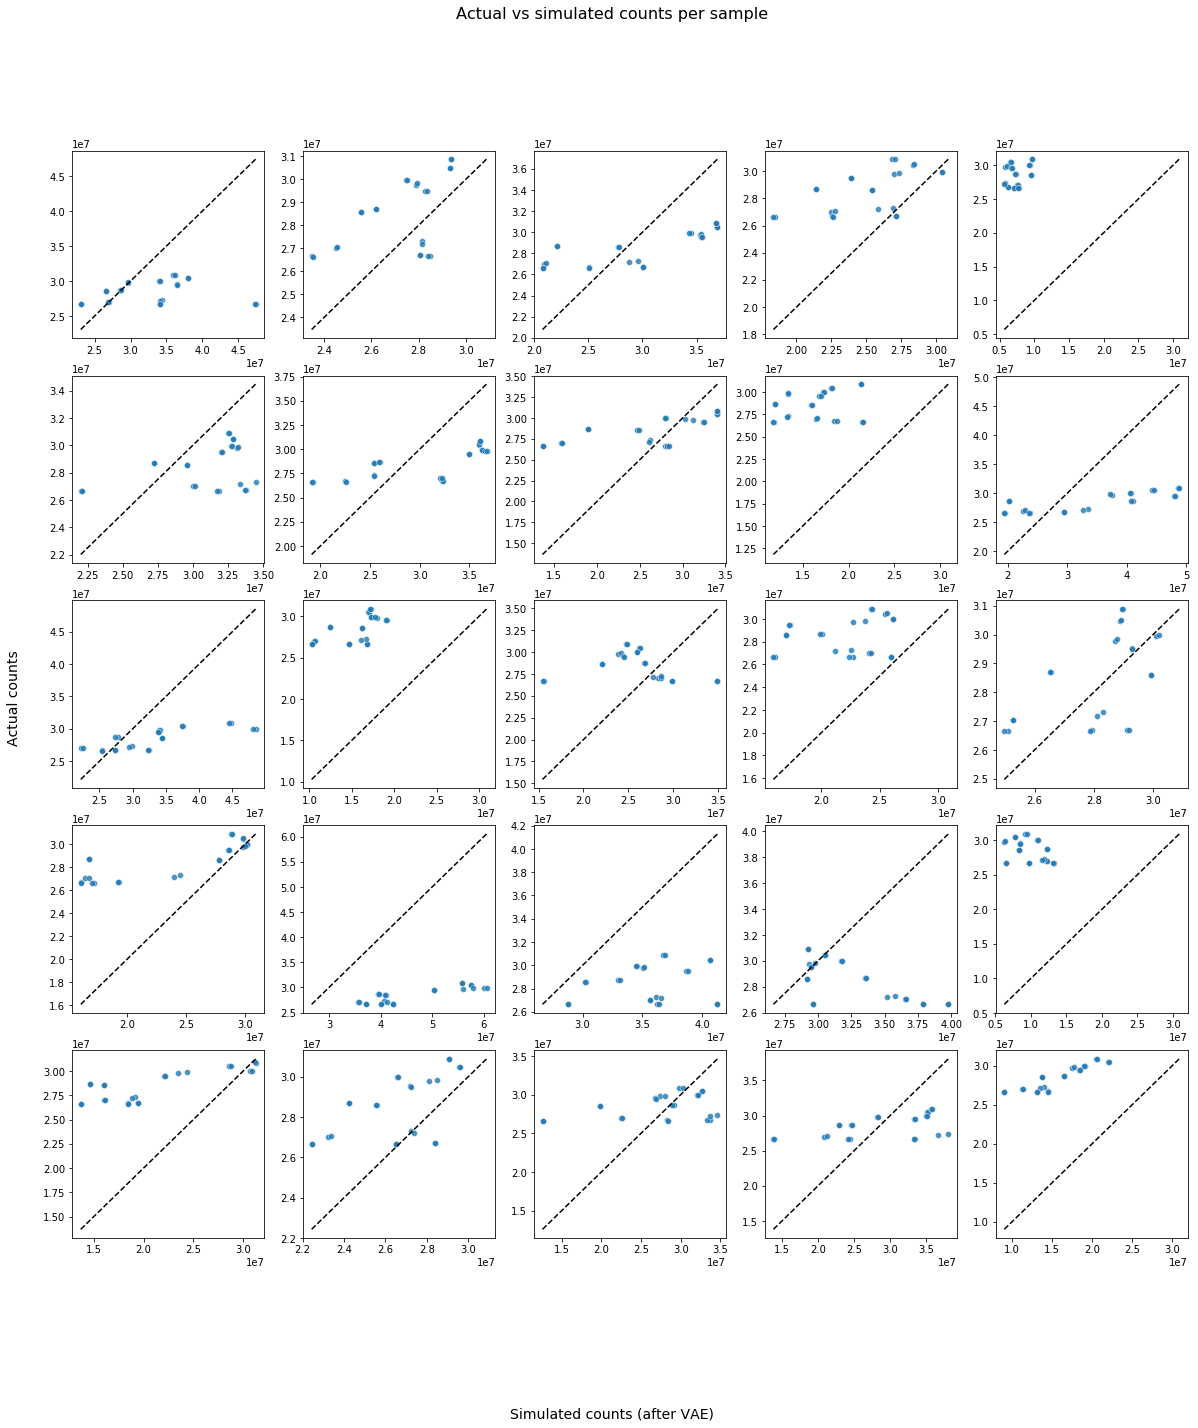

In [5]:
# Compare per sample
scatter_plot_original_vs_simulated(
    ncols=5,
    nrows=5,
    fig_width=20,
    fig_height=20,
    num_simulated=25,
    by_sample_or_gene="sample",
)

**Observations:**
* For about half of the cases, here is a horizontal trend that indicates that the variance in the actual total counts is lower compared to the simulated total counts. In other words the sequencing coverage of the actual experiment is consistent while the sequencing coverage of the simulated samples is variable.
* Overall, there are cases where most/all samples have a lower total read count in the simulated experiments compared to the actual experiment (when samples are all on one side of the diagonal). There are also cases where some samples have increased counts in the simulated experiment and some have decreased counts in the simulated experiment (i.e. when sample cross the diagonal).

**Takeaway:**
* These observations are consistent with our hypothesis that the total counts in the simulated experiment are different compared to the actual experiment and creating the opportunity for genes that to be DE that should not be.

* For example, say our actual experiment has some low sequencing coverage (i.e. total read counts) where a set of genes are not detectable (i.e. these genes have 0 read counts). After going through the VAE shifting process, some samples seem to have increased or decreased sequencing coverage compared to the actual sample. This will result in the same gene artificially having a change in read count due to the differences in sequencing coverage between samples.

* To correct for this we can try to re-scale the decoded counts per sample so that the sum of the simulated counts is equal to the sum of the actual total counts.

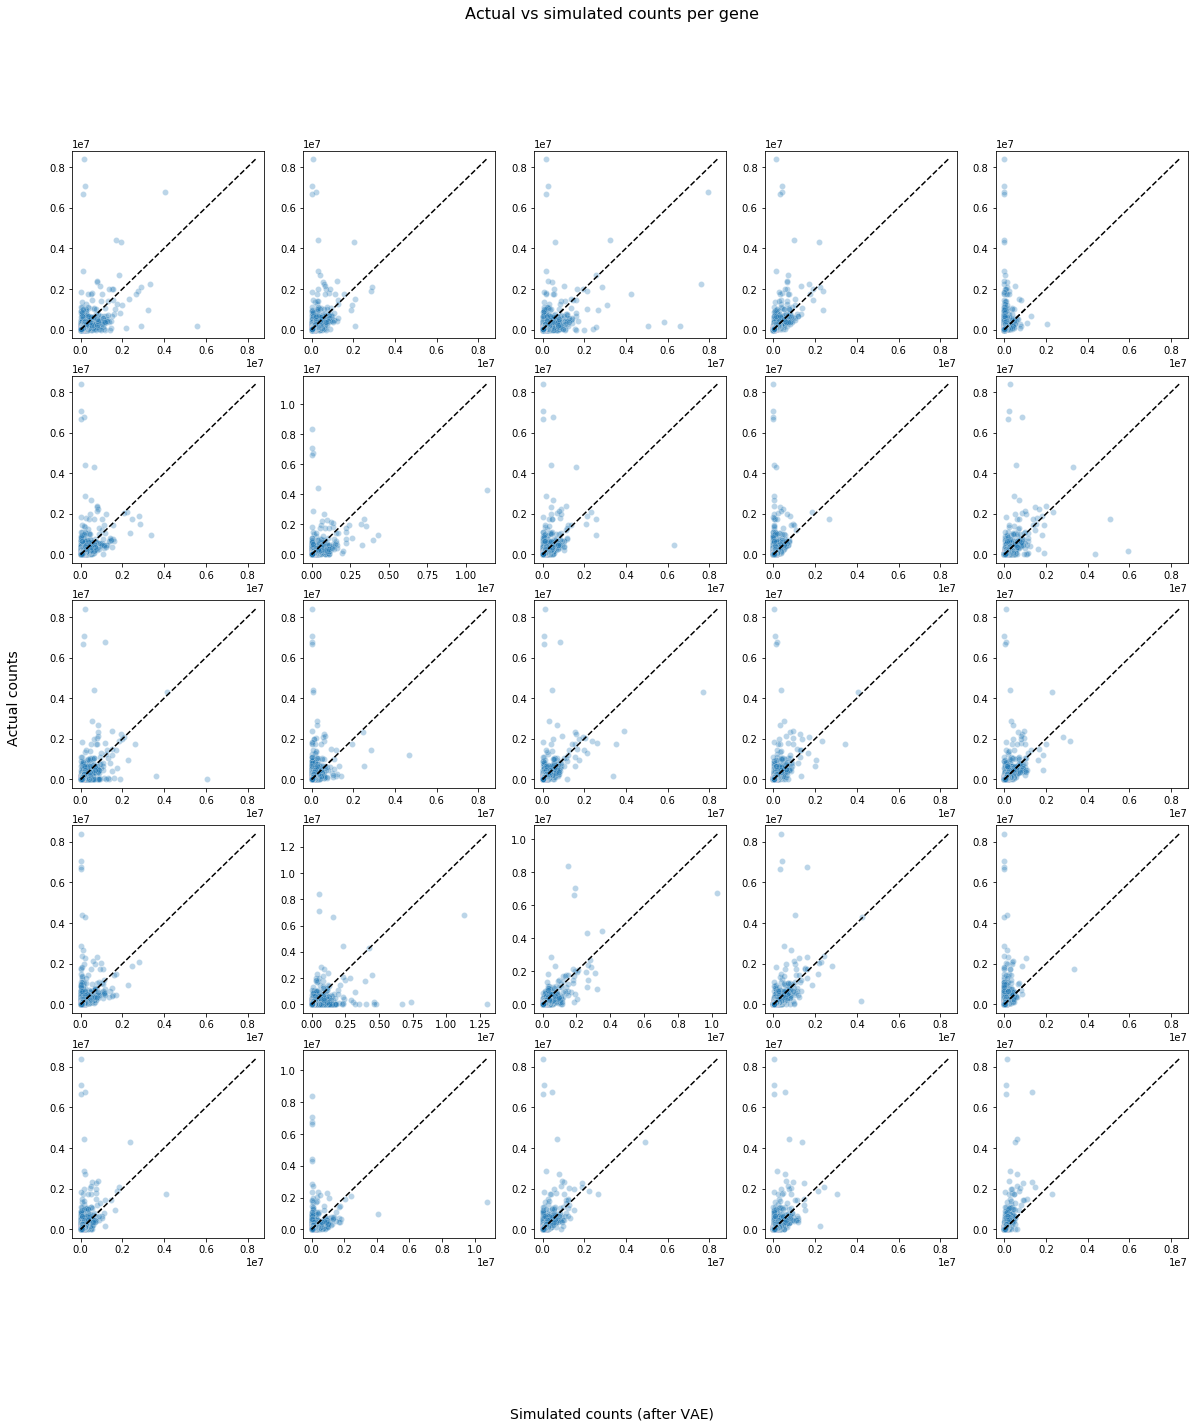

In [6]:
# Compare per gene
scatter_plot_original_vs_simulated(
    ncols=5,
    nrows=5,
    fig_width=20,
    fig_height=20,
    num_simulated=25,
    by_sample_or_gene="gene",
)

**Observations:**
* Since simulations are intended to produce different experiments, we don't expect the gene counts (activity) to be consistent between the actual vs simulated experiment which is what we see.

* Some genes that have high actual counts are reduced or increased in the simulated experiment